In [2]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB


In [3]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
# CRR parameters
reg_param = 5e4
mu = 20


img_name = 'M31'
# It could be any of these ['M31', 'W28', 'CYN', '3c288']

cmap = 'cubehelix'


# Load models and data

In [4]:
# %%
# Load image and mask
img, mat_mask = luq.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(
    np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape
)

phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()



INSTRUME                                                                         [astropy.io.fits.card]


In [5]:
# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(CRR_dir_name + exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


# Optimisation

In [6]:

# Prior parameters
lmbd = reg_param

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

# Accelerated gradient descend
for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Reality constraint
    x_hat = f.prox(x_hat)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )



[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1032 iterations


In [7]:
np_x_hat = to_numpy(x_hat)
np_x = np.copy(x)

# Evaluate performance
print('PSNR: ', psnr(np_x, np_x_hat, data_range=np_x.max()-np_x.min()))
print('SNR: ', luq.utils.eval_snr(x, np_x_hat))


PSNR:  55.260123685152436
SNR:  32.82


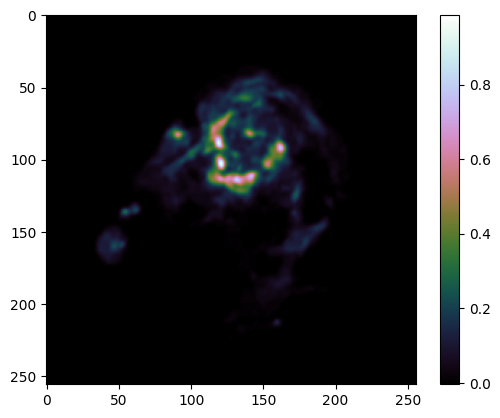

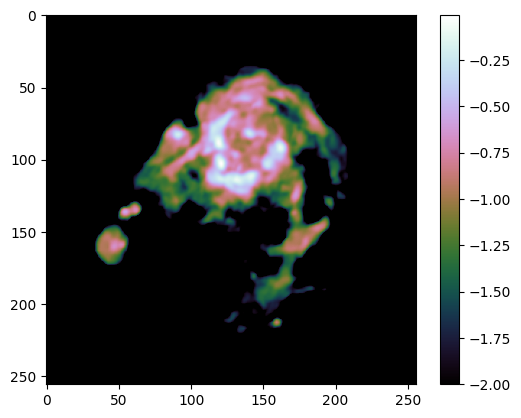

In [8]:
plt.figure()
plt.imshow(np_x_hat, cmap='cubehelix')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log10(abs(np_x_hat)), cmap='cubehelix', vmin=-2)
plt.colorbar()
plt.show()


# MAP-based pixel UQ

In [9]:
### MAP-based UQ

# Parameters
alpha_prob = 0.01
superpix_size = 8

# LCI compute parameters
LCI_iters = 200  # Max iterations
LCI_tol = 1e-4
LCI_bottom = -10
LCI_top = 10

# Clipping values for MAP-based LCI. Set as None for no clipping
clip_high_val = 1.
clip_low_val = 0.


In [10]:

# Function handle for the potential
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

# Evaluation of the potential
fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

# Compute HPD region bound
N = np_x_hat.size
tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
gamma_alpha = fun(x_hat).item() + tau_alpha*np.sqrt(N) + N


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


# New pixel UQ method

# Threshold coefficients

In [11]:
# Define the wavelet parameters
wavs_list = ['db8']
levels = 4

# Define the wavelet dict
# Define the l1 norm with dict psi
Psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

oper2wavelet = luq.operators.Operation2WaveletCoeffs_torch(Psi=Psi)


# Clone MAP estimation and cast type for wavelet operations
torch_img = torch.clone(x_hat).to(torch.float64)

torch_x = to_tensor(np_x).to(torch.float64)



In [12]:


def _potential_to_bisect(thresh, fun_np, oper2wavelet, torch_img):

    thresh_img = oper2wavelet.full_op_threshold_img(torch_img, thresh)

    return gamma_alpha - fun_np(thresh_img)

# Evaluation of the potential
potential_to_bisect = partial(
    _potential_to_bisect,
    fun_np=fun_np,
    oper2wavelet=oper2wavelet,
    torch_img=torch_img
)


In [13]:
start_interval = [0, 10]
iters = 5e2
tol = 1e-2

selected_thresh = luq.map_uncertainty.bisection_method(
    potential_to_bisect, start_interval, iters, tol
)

select_thresh_img = oper2wavelet.full_op_threshold_img(torch_img, selected_thresh)

print('selected_thresh: ', selected_thresh)
print('gamma_alpha: ', gamma_alpha)
print('MAP image: ', fun_np(torch_img.squeeze()))
print('thresholded image: ', fun_np(select_thresh_img))


/disk/xray0/tl3/repos/large-scale-UQ/large_scale_UQ/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


selected_thresh:  0.03326416015625
gamma_alpha:  100600.91931806403
MAP image:  32619.341796875
thresholded image:  101265.3828125


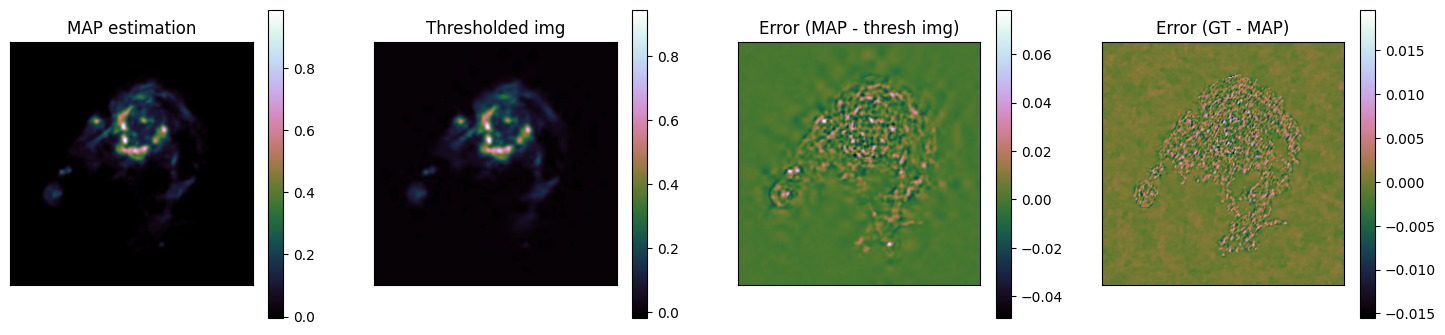

In [14]:
plt.figure(figsize=(18,4))

plt.subplot(141)
plt.imshow(to_numpy(torch_img), cmap=cmap)
plt.colorbar()
plt.title('MAP estimation')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(142)
plt.imshow(to_numpy(select_thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Thresholded img')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(143)
plt.imshow(to_numpy(torch_img - select_thresh_img), cmap=cmap)
plt.colorbar()
plt.title('Error (MAP - thresh img)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(144)
plt.imshow(np_x - np_x_hat, cmap=cmap)
plt.colorbar()
plt.title('Error (GT - MAP)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.show()




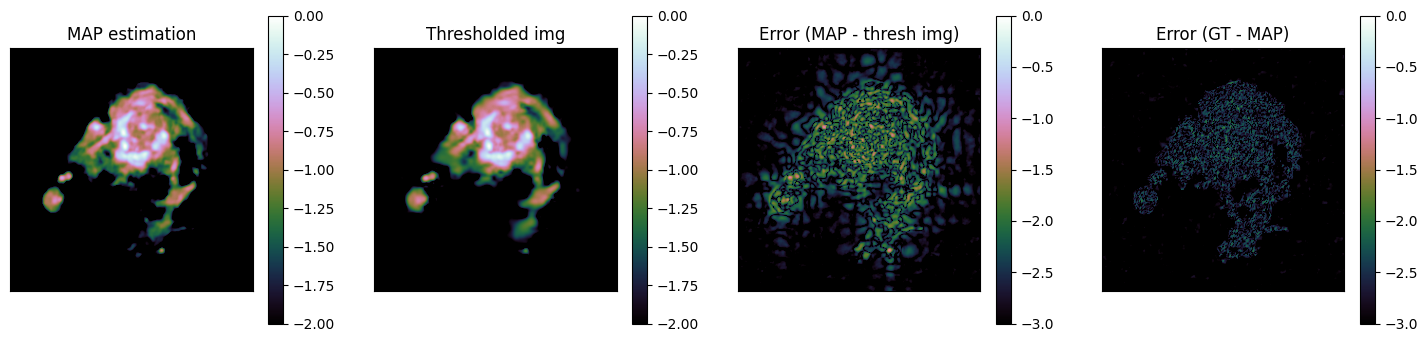

In [15]:

plt.figure(figsize=(18,4))

plt.subplot(141)
plt.imshow(np.log10(abs(to_numpy(torch_img))), cmap=cmap, vmax=0, vmin=-2)
plt.colorbar()
plt.title('MAP estimation')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(142)
plt.imshow(np.log10(abs(to_numpy(select_thresh_img))), cmap=cmap, vmax=0, vmin=-2)
plt.colorbar()
plt.title('Thresholded img')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(143)
plt.imshow(np.log10(abs(to_numpy(torch_img - select_thresh_img))), cmap=cmap, vmax=0, vmin=-3)
plt.colorbar()
plt.title('Error (MAP - thresh img)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.subplot(144)
plt.imshow(np.log10(abs(np_x - np_x_hat)), cmap=cmap, vmax=0, vmin=-3)
plt.colorbar()
plt.title('Error (GT - MAP)')
ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

plt.show()




### Error from scales and SNR

In [17]:

# I need to swap scales 

# torch_img -> MAP
# select_thresh_img -> Thresholded MAP image

print('SNR with respect to the MAP')

print('SNR at all levels: \t{:f}'.format(luq.utils.eval_snr(to_numpy(torch_img), to_numpy(select_thresh_img))))

for modif_level in range(5):

    op = lambda x1, x2: x2

    modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_img), torch.clone(select_thresh_img), op, level=modif_level)

    print('SNR at lvl {:d}: \t\t{:f}'.format(modif_level, luq.utils.eval_snr(to_numpy(torch_img), to_numpy(modif_img))))





SNR with respect to the MAP
SNR at all levels: 	22.610000
SNR at lvl 0: 		34.170000
SNR at lvl 1: 		29.910000
SNR at lvl 2: 		26.900000
SNR at lvl 3: 		27.200000
SNR at lvl 4: 		38.930000


In [18]:


print('SNR with respect to the GT')

print('SNR of the MAP: \t{:f}'.format(luq.utils.eval_snr(np_x, to_numpy(torch_img))))
print('SNR at all levels: \t{:f}'.format(luq.utils.eval_snr(np_x, to_numpy(select_thresh_img))))

for modif_level in range(5):

    op = lambda x1, x2: x2

    modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_img), torch.clone(select_thresh_img), op, level=modif_level)

    print('SNR at lvl {:d}: \t\t{:f}'.format(modif_level, luq.utils.eval_snr(np_x, to_numpy(modif_img))))


SNR with respect to the GT
SNR of the MAP: 	32.820000
SNR at all levels: 	21.640000
SNR at lvl 0: 		30.420000
SNR at lvl 1: 		27.910000
SNR at lvl 2: 		25.350000
SNR at lvl 3: 		25.450000
SNR at lvl 4: 		31.850000


SNR at lvl 0: 34.170000


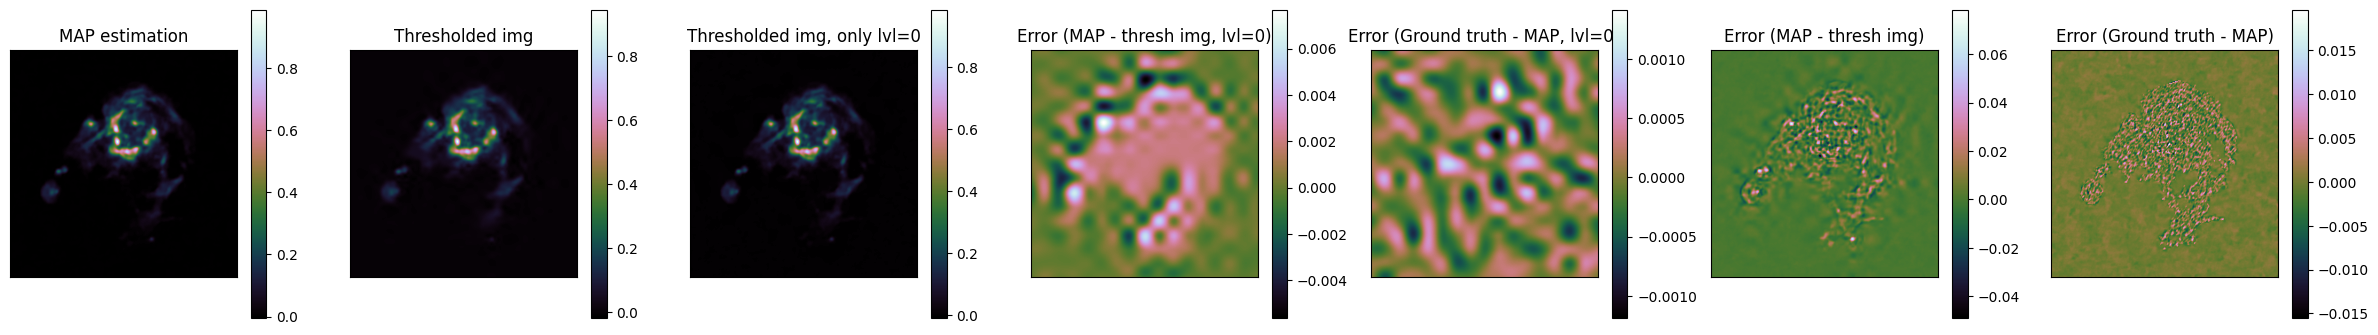

SNR at lvl 1: 29.910000


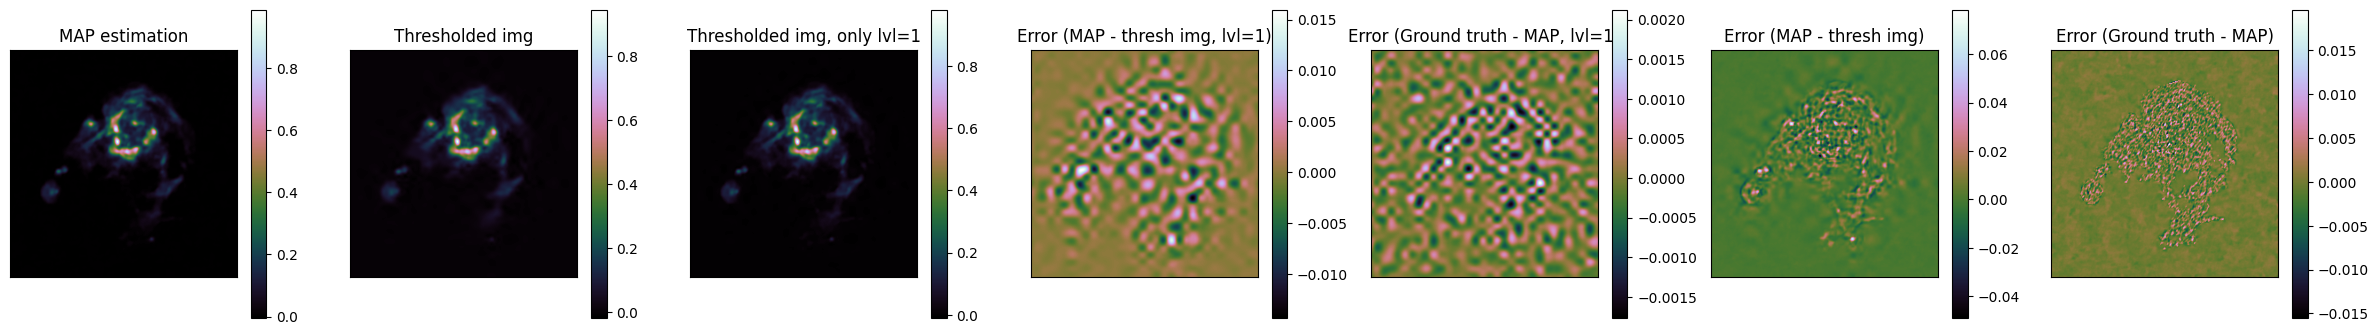

SNR at lvl 2: 26.900000


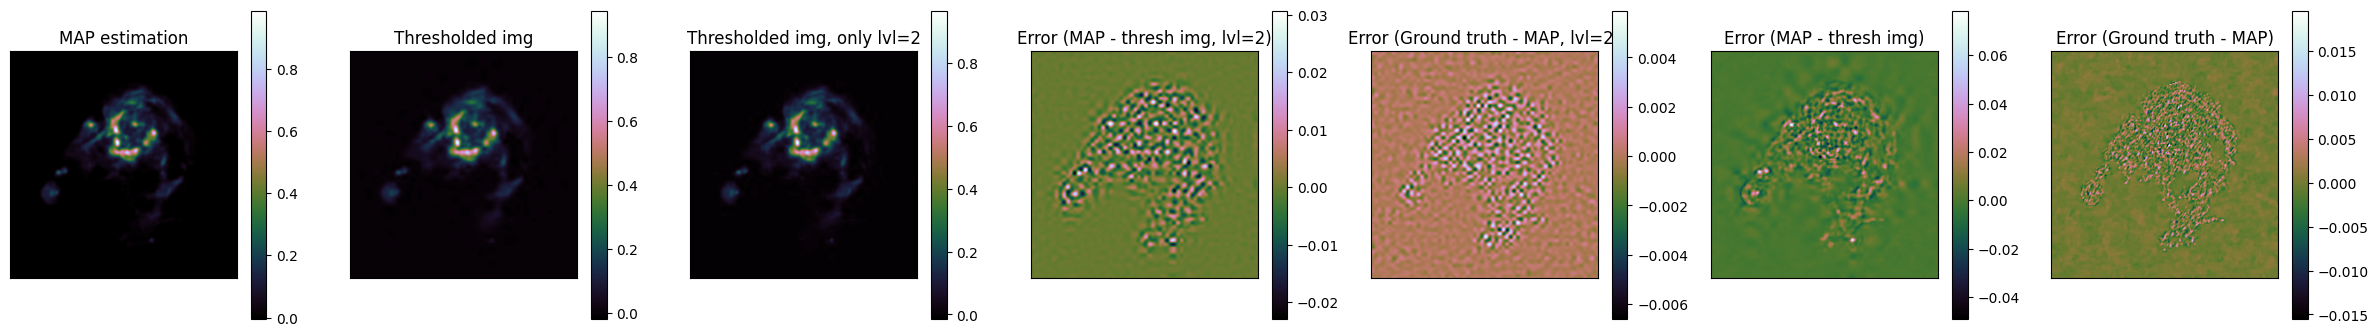

SNR at lvl 3: 27.200000


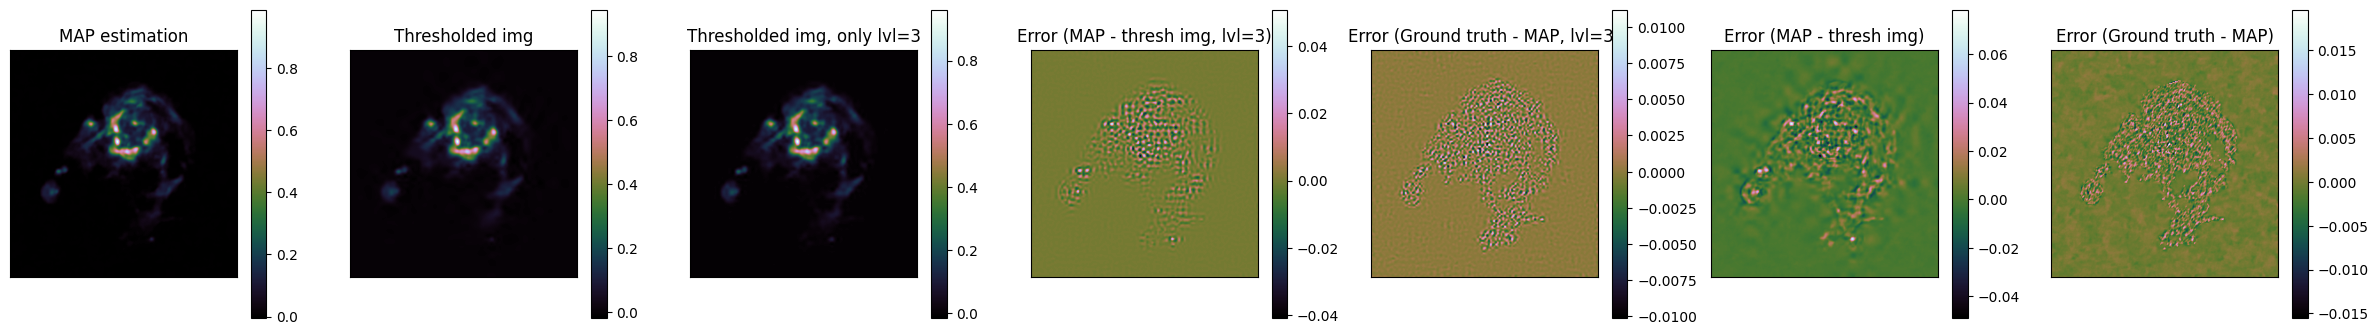

SNR at lvl 4: 38.930000


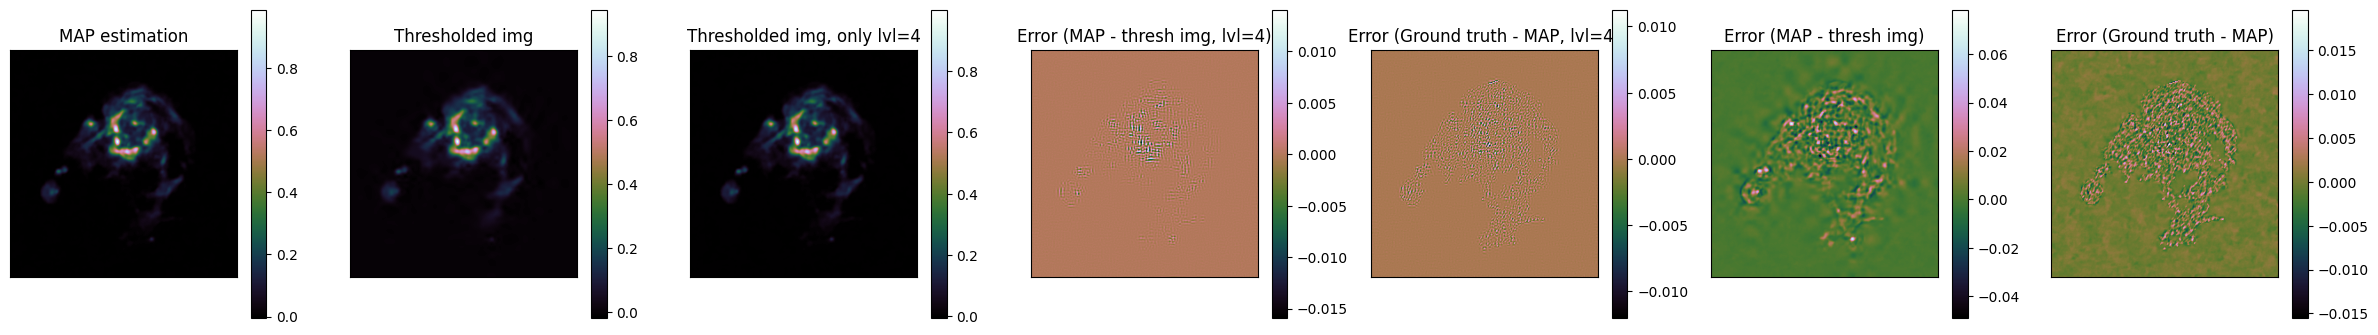

In [19]:
for modif_level in range(5):

    op = lambda x1, x2: x2

    modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_img), torch.clone(select_thresh_img), op, level=modif_level)
    GT_modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_x), torch.clone(torch_img), op, level=modif_level)

    print('SNR at lvl {:d}: {:f}'.format(modif_level, luq.utils.eval_snr(to_numpy(torch_img), to_numpy(modif_img))))

    plt.figure(figsize=(30,4))

    plt.subplot(171)
    plt.imshow(to_numpy(torch_img), cmap=cmap)
    plt.colorbar()
    plt.title('MAP estimation')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(172)
    plt.imshow(to_numpy(select_thresh_img), cmap=cmap)
    plt.colorbar()
    plt.title('Thresholded img')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(173)
    plt.imshow(to_numpy(modif_img), cmap=cmap)
    plt.colorbar()
    plt.title('Thresholded img, only lvl={:d}'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(174)
    plt.imshow(to_numpy(torch_img - modif_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - thresh img, lvl={:d})'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(175)
    plt.imshow(np_x - to_numpy(GT_modif_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (Ground truth - MAP, lvl={:d})'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(176)
    plt.imshow(to_numpy(torch_img - select_thresh_img), cmap=cmap)
    plt.colorbar()
    plt.title('Error (MAP - thresh img)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(177)
    plt.imshow(np_x - np_x_hat, cmap=cmap)
    plt.colorbar()
    plt.title('Error (Ground truth - MAP)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.show()


SNR at lvl 0: 34.170000


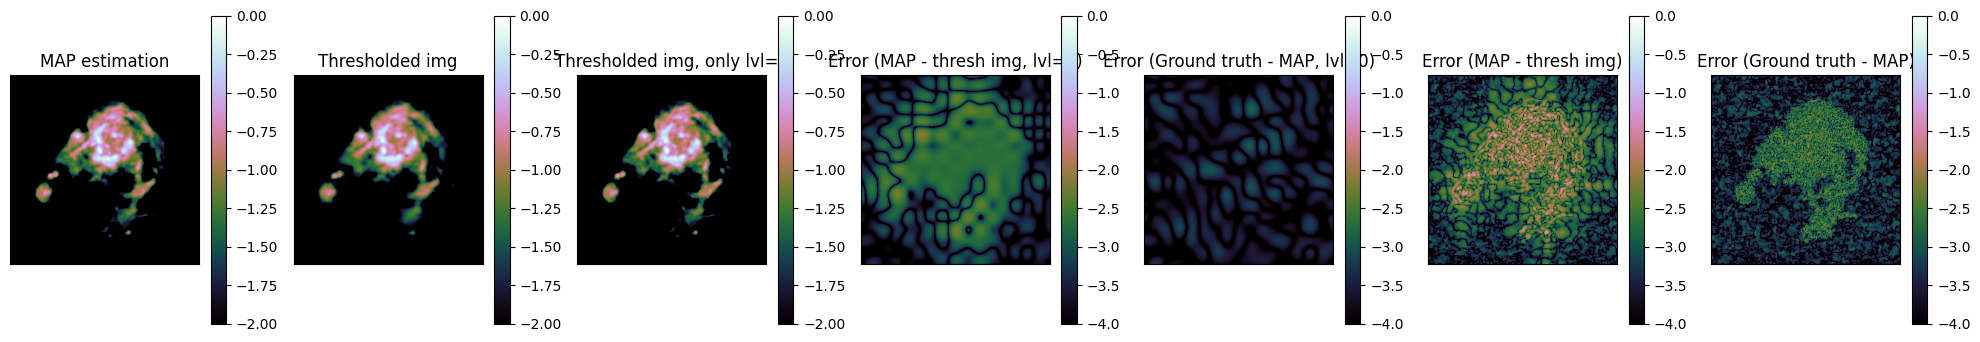

SNR at lvl 1: 29.910000


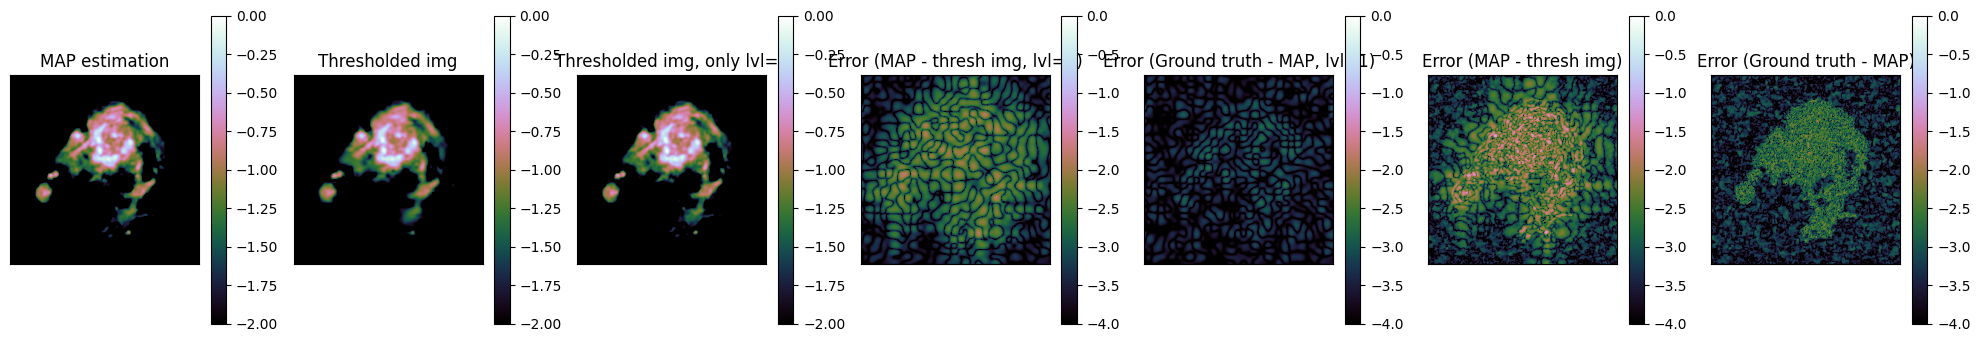

SNR at lvl 2: 26.900000


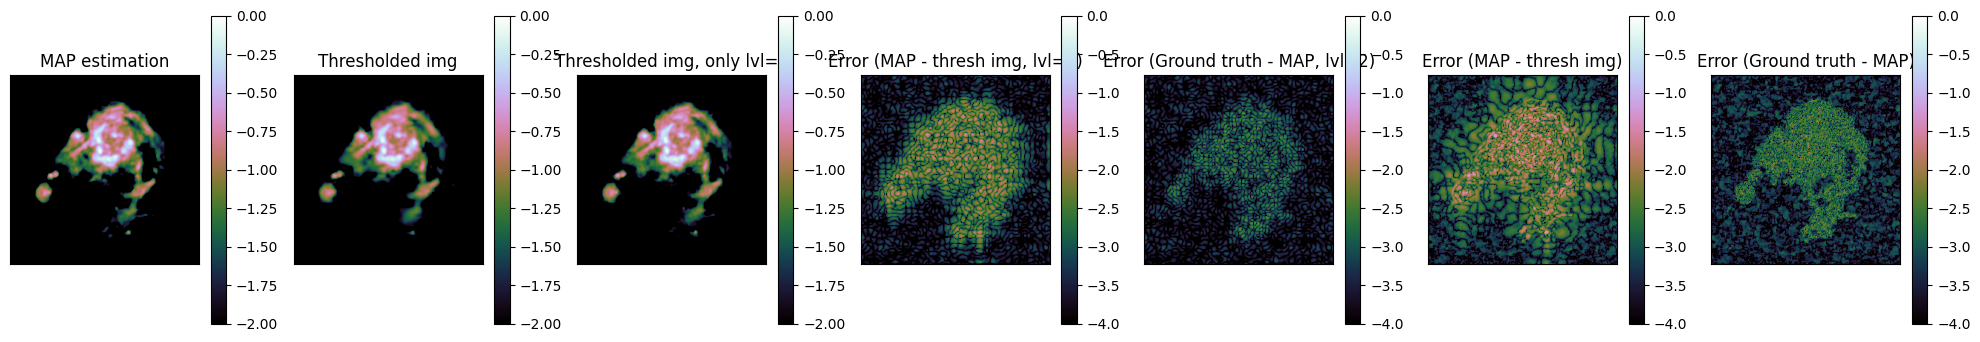

SNR at lvl 3: 27.200000


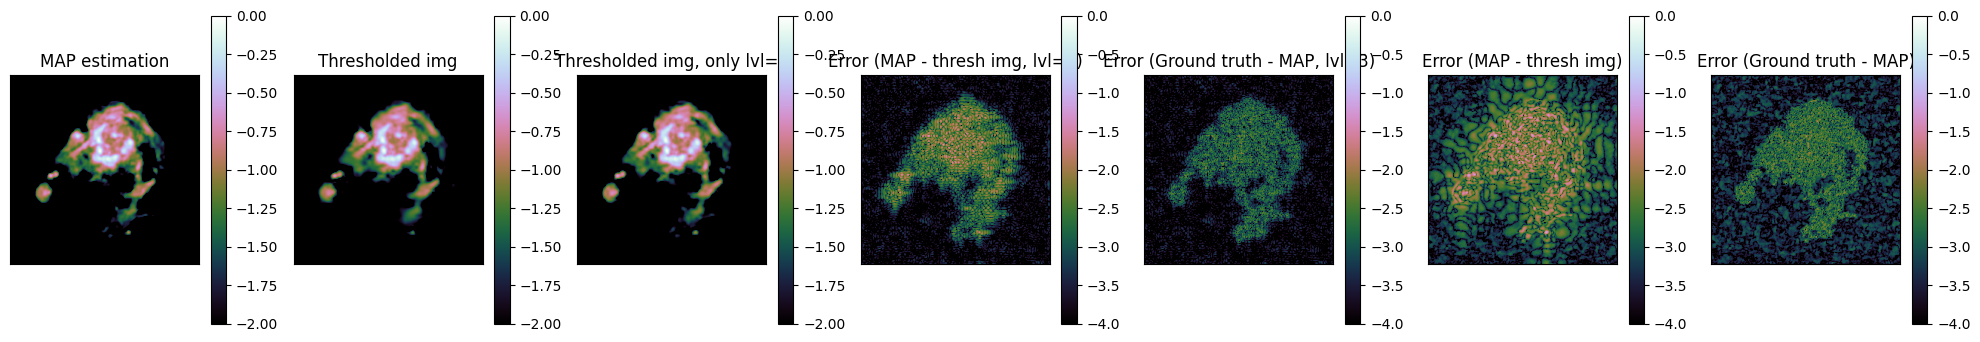

SNR at lvl 4: 38.930000


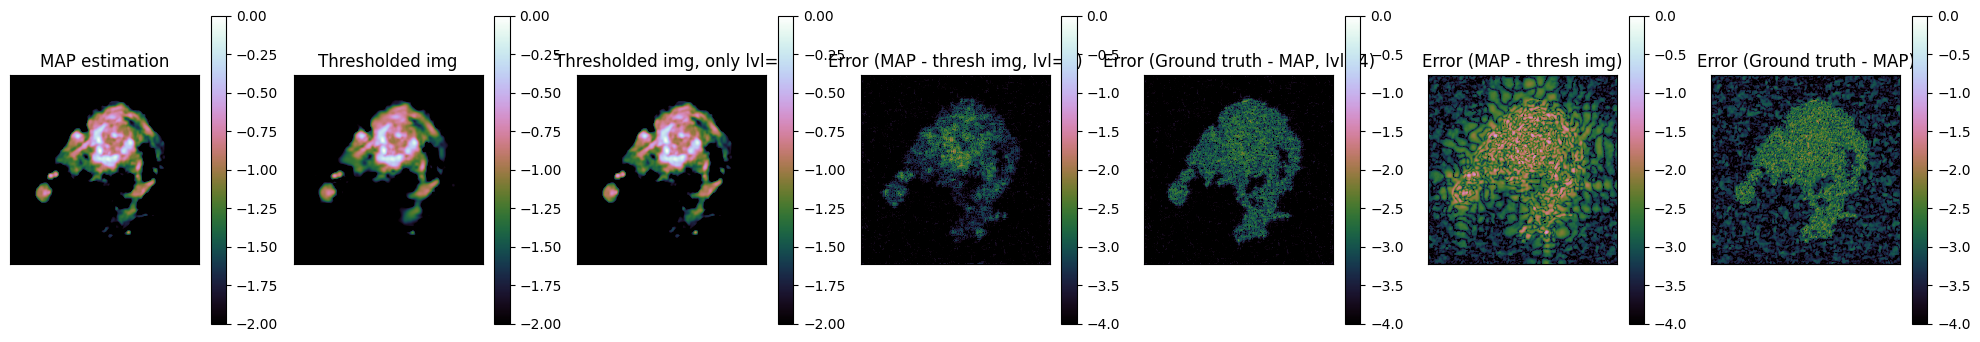

In [20]:

for modif_level in range(5):

    op = lambda x1, x2: x2

    modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_img), torch.clone(select_thresh_img), op, level=modif_level)
    GT_modif_img = oper2wavelet.full_op_two_img(torch.clone(torch_x), torch.clone(torch_img), op, level=modif_level)

    print('SNR at lvl {:d}: {:f}'.format(modif_level, luq.utils.eval_snr(to_numpy(torch_img), to_numpy(modif_img))))

    plt.figure(figsize=(25,4))

    plt.subplot(171)
    plt.imshow(np.log10(abs(to_numpy(torch_img))), cmap=cmap, vmax=0, vmin=-2)
    plt.colorbar()
    plt.title('MAP estimation')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(172)
    plt.imshow(np.log10(abs(to_numpy(select_thresh_img))), cmap=cmap, vmax=0, vmin=-2)
    plt.colorbar()
    plt.title('Thresholded img')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(173)
    plt.imshow(np.log10(abs(to_numpy(modif_img))), cmap=cmap, vmax=0, vmin=-2)
    plt.colorbar()
    plt.title('Thresholded img, only lvl={:d}'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(174)
    plt.imshow(np.log10(abs(to_numpy(torch_img - modif_img))), cmap=cmap, vmax=0, vmin=-4)
    plt.colorbar()
    plt.title('Error (MAP - thresh img, lvl={:d})'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(175)
    plt.imshow(np.log10(abs(np_x - to_numpy(GT_modif_img))), cmap=cmap, vmax=0, vmin=-4)
    plt.colorbar()
    plt.title('Error (Ground truth - MAP, lvl={:d})'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(176)
    plt.imshow(np.log10(abs(to_numpy(torch_img - select_thresh_img))), cmap=cmap, vmax=0, vmin=-4)
    plt.colorbar()
    plt.title('Error (MAP - thresh img)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(177)
    plt.imshow(np.log10(abs(np_x - np_x_hat)), cmap=cmap, vmax=0, vmin=-4)
    plt.colorbar()
    plt.title('Error (Ground truth - MAP)')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.show()




# Compute Posterior standard deviation at different wavelet levels

In [26]:

load_var_dir = '/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/CRR/vars/'

map_vars_path = load_var_dir + 'M31_CRR_UQ_MAP_lmbd_5.0e+04_MAP_vars.npy'
samp_vars_path = load_var_dir + 'M31_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_vars.npy'
samples_path = load_var_dir + 'M31_SKROCK_CRR_lmbd_5.0e+04_mu_2.0e+01_nsamples_5.0e+04_thinning_1.0e+01_samples.npy'

map_vars = np.load(map_vars_path, allow_pickle=True)[()]
samp_vars = np.load(samp_vars_path, allow_pickle=True)[()]
samples = np.load(samples_path, allow_pickle=True)

print('map_vars: ', map_vars.keys())
print('samp_vars: ', samp_vars.keys())
print('samples.shape: ', samples.shape)


map_vars:  dict_keys(['x_ground_truth', 'x_map', 'x_init', 'opt_params', 'hpd_results', 'error_p_arr', 'error_m_arr', 'mean_img_arr', 'gt_mean_img_arr', 'computing_time', 'superpix_sizes', 'LCI_params'])
samp_vars:  dict_keys(['X_ground_truth', 'X_dirty', 'X_MAP', 'X_MMSE', 'post_meanvar', 'absfouriercoeff', 'logpi_thinning_trace', 'X', 'quantiles', 'st_dev_down', 'means_list', 'params', 'elapsed_time'])


In [29]:
np_x = samp_vars['X_ground_truth']
x_map = map_vars['x_map']
x_mmse = samp_vars['X_MMSE']
post_meanvar = samp_vars['post_meanvar']
x_sampling_var = post_meanvar.get_var().detach().cpu().squeeze()

torch_x_map = to_tensor(x_map).to(torch.float64)
torch_x_mmse = to_tensor(x_mmse).to(torch.float64)
torch_x_gt = to_tensor(np_x).to(torch.float64)


In [45]:

op = lambda x1, x2: x2

saved_st_dev = []

for modif_level in range(5):

    modif_samples = np.array([to_numpy(oper2wavelet.full_op_two_img(
        torch.clone(torch_x_mmse),
        to_tensor(sample).to(torch.float64),
        op,
        level=modif_level
    )) for sample in samples])

    # Compute pixel SD
    meanSample_down = np.mean(modif_samples, 0) 
    second_moment_down = np.mean(modif_samples**2, 0)
    st_dev_modif_samples = np.sqrt(second_moment_down - meanSample_down**2)

    saved_st_dev.append(st_dev_modif_samples)



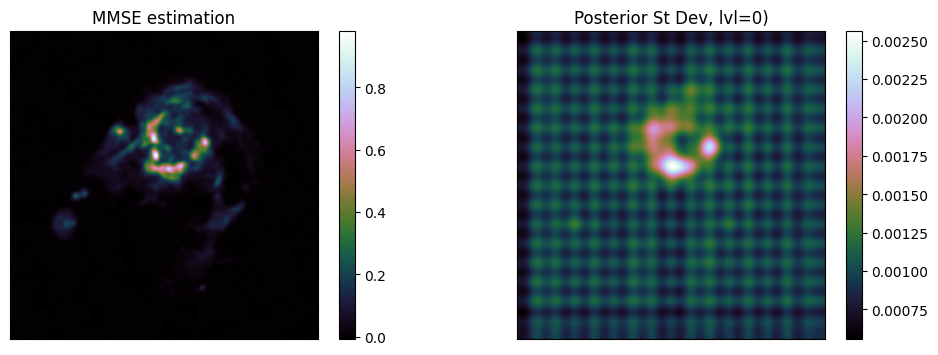

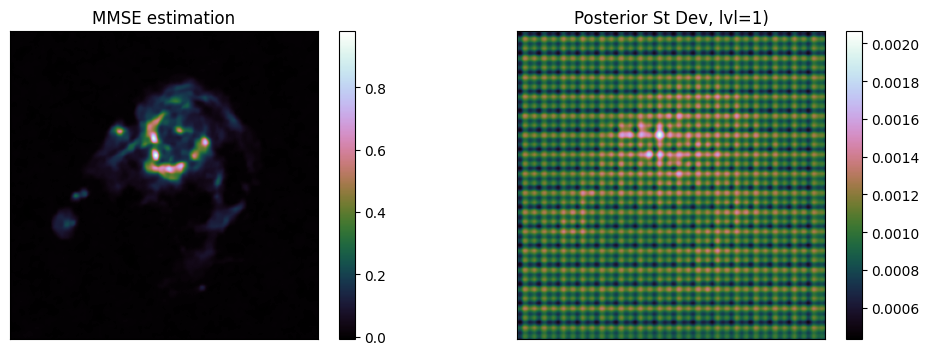

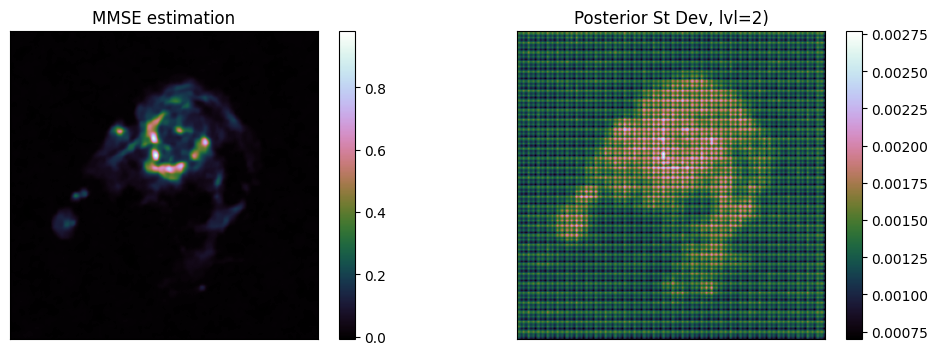

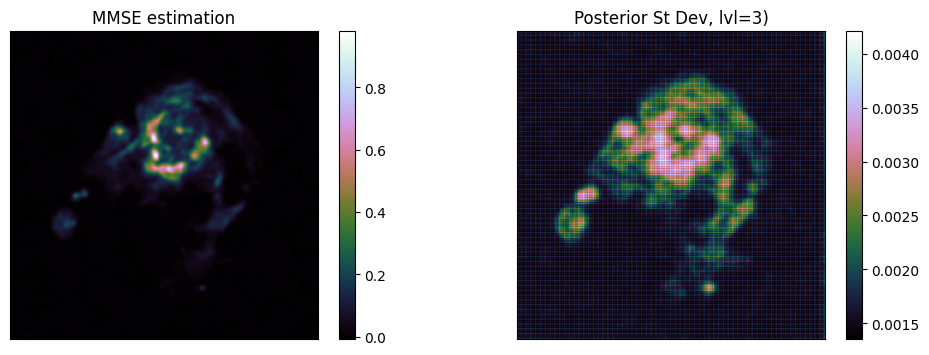

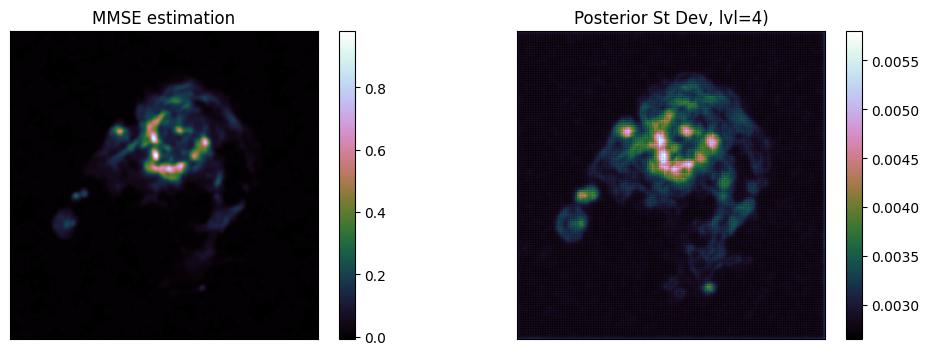

In [50]:

for modif_level in range(5):

    plt.figure(figsize=(12,4))

    plt.subplot(121)
    plt.imshow(x_mmse, cmap=cmap)#, vmax=0, vmin=-2)
    plt.colorbar()
    plt.title('MMSE estimation')
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.subplot(122)
    plt.imshow(saved_st_dev[modif_level], cmap=cmap)#, vmax=0, vmin=-4)
    plt.colorbar()
    plt.title('Posterior St Dev, lvl={:d})'.format(modif_level))
    ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    # plt.subplot(143)
    # plt.imshow(np.log10(abs(to_numpy(torch_img - select_thresh_img))), cmap=cmap, vmax=0, vmin=-3)
    # plt.colorbar()
    # plt.title('Error (MAP - thresh img)')
    # ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    # plt.subplot(144)
    # plt.imshow(np.log10(abs(np_x - np_x_hat)), cmap=cmap, vmax=0, vmin=-3)
    # plt.colorbar()
    # plt.title('Error (GT - MAP)')
    # ax = plt.gca();ax.set_yticks([]);ax.set_xticks([])

    plt.show()



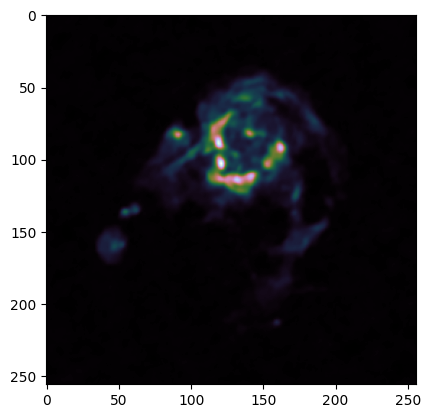

In [34]:

plt.figure()
plt.imshow(to_numpy(GT_modif_img), cmap=cmap)
plt.show()


In [37]:
modif_samples = np.array(modif_samples)

In [39]:

# Compute pixel SD
meanSample_down = np.mean(modif_samples, 0) 
second_moment_down = np.mean(modif_samples**2, 0)
st_dev_modif_samples = np.sqrt(second_moment_down - meanSample_down**2)


In [40]:

st_dev_modif_samples.shape


(256, 256)

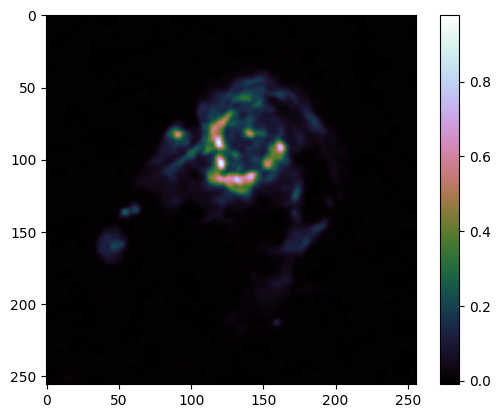

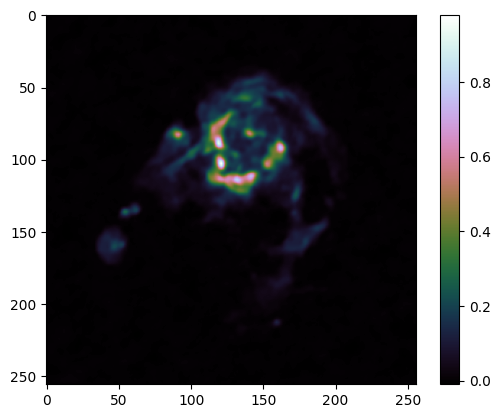

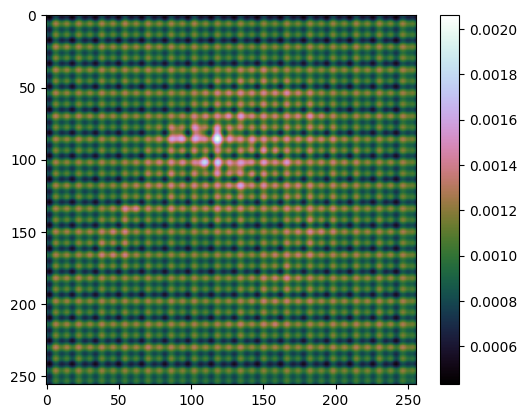

In [44]:
plt.figure()
plt.imshow(x_mmse, cmap=cmap)
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(modif_samples[10,:,:], cmap=cmap)
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(st_dev_modif_samples, cmap=cmap)
plt.colorbar()
plt.show()
